In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from datetime import date,timedelta
import datetime as dt

import seaborn as sns
import squarify
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Data processing
from sklearn.preprocessing import StandardScaler

# Module perso : helpers
import helpers# Le module du fichier python helper.py

pd.set_option("display.max_rows", 5000)
pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
Image(url= "https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,f_auto,q_auto:eco/uhmzrudyjsw1faowuckg", width=200, height=200) 

# <span class="bg-primary">Segmentation RFM<span>

# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__
    
Fournir aux équipes d'OLIST, entreprise du e-commerce, une __segmentation des clients__ afin qu'elles puissent l'utiliser dans leurs campagnes de communication :
    
- Comprendre les différents types d'utilisateurs (comportements, données personnelles)
- Fournir une description actionable de la segmentation
- Proposer un contrat de maintenance

# <span class="bg-danger">Sommaire<span>
___
__<span class="bg-info">1.<span>__ __Chargement__ de la table RFM
___
__<span class="bg-info">2.<span>__ __Création de la table de segmentation RFM__
    
__<span class="bg-warning">2_1.<span>__ __Détermination__ des quantiles
___
__<span class="bg-warning">2_2.<span>__ __Création__ de la table de segmentation RFM
___ 
__<span class="bg-info">3.<span>__ __Visualisation__ de la segmentation
___
__<span class="bg-warning">3_1.<span>__ __Diagramme__ en barres
___
__<span class="bg-warning">3_2.<span>__ __Squarify plot__
___     
__<span class="bg-info">4.<span>__ __Stabilité__ de la clientèle sur 6 mois
___
__<span class="bg-warning">4_1.<span>__ __Création__ des segments clients sur 6 mois
___
__<span class="bg-warning">4_2.<span>__ __Visualisation__ Sankey diagram
___
__<span class="bg-success">4_2_1<span>__ __Stabilité sur 1 mois juillet à août 18__ Sankey diagram 
___
__<span class="bg-success">4_2_2<span>__ __Stabilité sur 3 mois mai à août 18__ Sankey diagram
___
__<span class="bg-success">4_2_3<span>__ __Stabilité sur 6 mois mars à août 18__ Sankey diagram   
___
__<span class="bg-success">4_2_4<span>__ __Stabilité par morceaux PARTIE 1 : mars à mai 18__ Sankey diagram 
___
__<span class="bg-success">4_2_5<span>__ __Stabilité par morceaux PARTIE 2 : mai à juillet 18__ Sankey diagram    
___
__<span class="bg-success">4_2_6<span>__ __Stabilité par morceaux VUE D'ENSEMBLE : mars/ mai/ juillet/ août 18__ Sankey diagram 
___
__<span class="bg-success">4_2_6<span>__ __Stabilité des VIP, VUE D'ENSEMBLE : mars/ mai/ juillet/ août 18__ Sankey diagram
___    
__<span class="bg-info">5.<span>__ __Contrat de maintenance :__ cas des nouveaux clients, action à envisager avant MAJ
___         

## <span class="bg-info"> 1. Chargement de la table RFM<span>

### Score RFM
- __Récence__ : Nombre de jours depuis le dernier achat du client
- __Fréquence__ : Nombre de commandes réalisées par le client
- __Montant__ : Nombre d'argent dépensé par transaction

In [3]:
# chargement de la table RFM
df_rfm = pd.read_csv('data_RFM_olist.csv')

In [4]:
df_rfm.head()

,customer_unique_id,récence,fréquence,valeur_monétaire
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [5]:
df_rfm.shape

(91133, 4)

In [6]:
client_1 = df_rfm[df_rfm['customer_unique_id']=='000fbf0473c10fc1ab6f8d2d286ce20c']
client_1

,customer_unique_id,récence,fréquence,valeur_monétaire
22,000fbf0473c10fc1ab6f8d2d286ce20c,35,4,1449.52


## <span class="bg-info"> 2. Création de la table de segmentation RFM<span>

__Répartition des clients en 4 segments__ (choisis au hasard)

Récence/Fréquence/Valeur monétaire : Niveau 4 > Niveau 3> Niveau 2 > Niveau 1

- Plus le niveau de récence est bas, plus le niveau de récence est élevé
- Plus le nombre de commandes est élevé, plus le niveau de fréquence est élevé
- Plus la valeur monétaire est élevée, plus le niveau de la valeur monétaire est élevé

### <span class="bg-success"> 2.1 Détermination des quantiles<span>

In [7]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles.head()

,récence,fréquence,valeur_monétaire
0.25,114.0,1.0,63.50
0.50,218.0,1.0,112.09
0.75,345.0,1.0,199.15


In [8]:
quantiles = quantiles.to_dict() # Transformation en dictionnaire, plus facile à utiliser

### <span class="bg-success"> 2.2 Création de la table de segmentation RFM<span>

In [9]:
df_rfm_segmentation = df_rfm.copy()

### __Segmentation__

In [10]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
# 1 ceux qui ont commandé récemment, 4 ceux qui n'ont pas commandé depuis longtemps
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4 # > 0.75
    
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
#1 ceux qui dépensent le plus, 4 ceux qui dépensent le moins
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [11]:
df_rfm_segmentation['R_Quartile'] = df_rfm_segmentation['récence'].apply(RScore, args=('récence',quantiles))
df_rfm_segmentation['F_Quartile'] = df_rfm_segmentation['fréquence'].apply(FMScore, args=('fréquence', quantiles))
df_rfm_segmentation['M_Quartile'] = df_rfm_segmentation['valeur_monétaire'].apply(FMScore, args=('valeur_monétaire',quantiles))

### Score RFM

Maintenant que nous avons le score de chaque client, nous pouvons représenter notre segmentation de la clientèle. 

Tout d'abord, nous devons __combiner les scores (R_Quartile, F_Quartile,M_Quartile).__

In [12]:
df_rfm_segmentation['RFMScore'] = df_rfm_segmentation.R_Quartile.map(str) \
                            + df_rfm_segmentation.F_Quartile.map(str) \
                            + df_rfm_segmentation.M_Quartile.map(str)

In [13]:
df_rfm_segmentation.head(10)

,customer_unique_id,récence,fréquence,valeur_monétaire,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,1,4,2,142
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,2,4,4,244
2,0000f46a3911fa3c0805444483337064,537,1,86.22,4,4,3,443
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,3,4,4,344
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,3,4,2,342
5,0004bd2a26a76fe21f786e4fbd80607f,146,1,166.98,2,4,2,242
6,00050ab1314c0e55a6ca13cf7181fecf,132,1,35.38,2,4,4,244
7,00053a61a98854899e70ed204dd4bafe,183,2,838.36,2,1,1,211
8,0005e1862207bf6ccc02e4228effd9a0,543,1,150.12,4,4,2,442
9,0005ef4cd20d2893f0d9fbd94d3c0d97,170,1,129.76,2,4,2,242


In [14]:
df_rfm_segmentation.to_csv('df_rfm_segmentation_olist.csv')

- __Meilleure score de récence__ = 1 : ceux dont le dernier achat est parmi les plus récents. 
- __Meilleur score de fréquence__ = 1 : ceux dont les achats sont les plus fréquents. 
- __Meilleur score de valeur_monétaire__ = 1 : ceux qui dépensent le plus.

### Segmentation clientèle en fonction du score :
- Meilleurs clients VIP : __RFMSCore : 111__
- Clients fidèles : __F_Quartile = 1__
- Clients dépensiers : __M_quartile = 1__
- VIP presque perdus : __RFMScore : 311__
- VIP clients perdus : __RFMScore 411__
- Clients non intéressés perdus : __RFMScore : 444__

In [15]:
#https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales
print("Meilleurs clients: ",len(df_rfm_segmentation[df_rfm_segmentation['RFMScore']=='111']))
print('Clients fidèles: ',len(df_rfm_segmentation[df_rfm_segmentation['F_Quartile']==1]))
print("Gros dépensiers: ",len(df_rfm_segmentation[df_rfm_segmentation['M_Quartile']==1]))
print('Meilleurs clients presque perdus: ', len(df_rfm_segmentation[df_rfm_segmentation['RFMScore']=='311']))
print('Meilleurs clients perdus: ',len(df_rfm_segmentation[df_rfm_segmentation['RFMScore']=='411']))
print('Clients non intéressés perdus : ',len(df_rfm_segmentation[df_rfm_segmentation['RFMScore']=='444']))

Meilleurs clients:  2345
Clients fidèles:  13260
Gros dépensiers:  22783
Meilleurs clients presque perdus:  2319
Meilleurs clients perdus:  2126
Clients non intéressés perdus :  5609


In [16]:
#10 meilleurs clients
df_rfm_segmentation[df_rfm_segmentation['RFMScore']=='111'].sort_values('valeur_monétaire', ascending=False).head(10);

### Ajout d'une colonne indicatrice "Segment" pour la visualisation:
- Meilleurs clients VIP
- Clients presque perdus
- Clients perdus
- Clients non intéressés perdus
- clients fidèles
- Clients dépensiers
- Autres clients

In [17]:
#Ajout de segments clients 
df_rfm_segmentation['segment'] = ""
mask1 = df_rfm_segmentation['RFMScore'] == '111'# vip
mask2 = df_rfm_segmentation['RFMScore'] == '311'#clients vip presque perdus
mask3 = df_rfm_segmentation['RFMScore'] == '411'# clients vip perdus
mask4 = df_rfm_segmentation['RFMScore'] == '444'# clients non intéressés perdus
mask5 = df_rfm_segmentation['RFMScore'] == '144'# nouveaux clients
# Autres clients
mask6 = (df_rfm_segmentation['RFMScore'] != '444') & (df_rfm_segmentation['RFMScore'] != '411') & (df_rfm_segmentation['RFMScore'] != '311') & (df_rfm_segmentation['RFMScore'] != '111') & (df_rfm_segmentation['RFMScore'] != '144')
# Clients fidèles dans autres clients
mask7 = (df_rfm_segmentation['F_Quartile'] == 1) & (df_rfm_segmentation['RFMScore'] != '444') & (df_rfm_segmentation['RFMScore'] != '411') & (df_rfm_segmentation['RFMScore'] != '311') & (df_rfm_segmentation['RFMScore'] != '111') & (df_rfm_segmentation['RFMScore'] != '144')
# Clients dépensiers dans autres clients
mask8 = (df_rfm_segmentation['M_Quartile'] == 1) & (df_rfm_segmentation['RFMScore'] != '444') & (df_rfm_segmentation['RFMScore'] != '411') & (df_rfm_segmentation['RFMScore'] != '311') & (df_rfm_segmentation['RFMScore'] != '111') & (df_rfm_segmentation['RFMScore'] != '144')

df_rfm_segmentation.loc[mask1, 'segment'] = 'Meilleurs clients VIP'
df_rfm_segmentation.loc[mask2, 'segment'] = 'Clients VIP presque perdus'
df_rfm_segmentation.loc[mask3, 'segment'] = 'Clients VIP perdus'
df_rfm_segmentation.loc[mask4, 'segment'] = 'Clients non intéressés perdus'
df_rfm_segmentation.loc[mask5, 'segment'] = 'Nouveaux clients'
df_rfm_segmentation.loc[mask6, 'segment'] = 'Autres clients'
df_rfm_segmentation.loc[mask7, 'segment'] = 'Clients fidèles'
df_rfm_segmentation.loc[mask8, 'segment'] = 'Clients dépensiers'

In [18]:
# create new dataframe with transformed values
df_rfm_segmentation_t = df_rfm_segmentation.copy()

ss = StandardScaler()
df_rfm_segmentation_t['récence'] = ss.fit_transform(df_rfm_segmentation['récence'].values.reshape(-1,1))
df_rfm_segmentation_t['fréquence'] = ss.fit_transform(df_rfm_segmentation['fréquence'].values.reshape(-1,1))
df_rfm_segmentation_t['valeur_monétaire'] = ss.fit_transform(df_rfm_segmentation['valeur_monétaire'].values.reshape(-1,1))

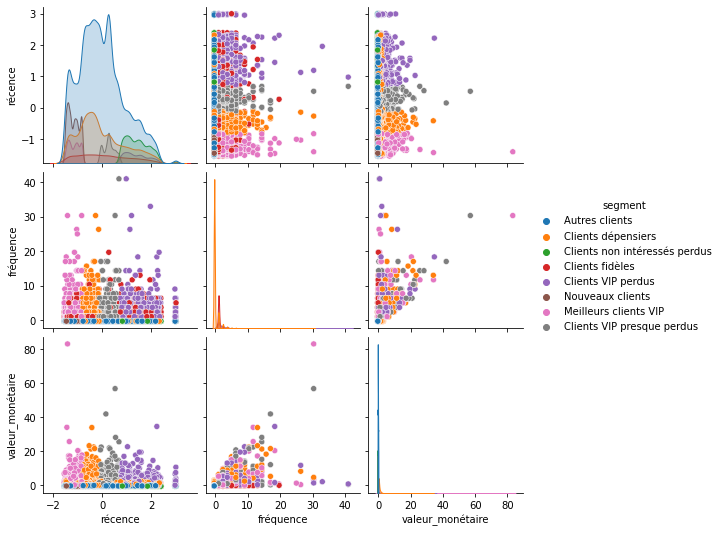

In [19]:
#### Pairplot avec 3 colonnes, selon segments clientèle
sns.pairplot(df_rfm_segmentation_t, vars = ['récence','fréquence','valeur_monétaire'], hue="segment")

In [20]:
df_rfm_segmentation[df_rfm_segmentation['segment'] == 'Clients non intéressés perdus'];

In [21]:
df_rfm_segmentation.to_csv('data_rfm_olist.csv')

## <span class="bg-info"> 3. Visualisation de la segmentation<span>

### <span class="bg-success"> 3.1 Visualisation : Diagramme en barres<span>

<AxesSubplot:xlabel='segment', ylabel='customer_unique_id'>

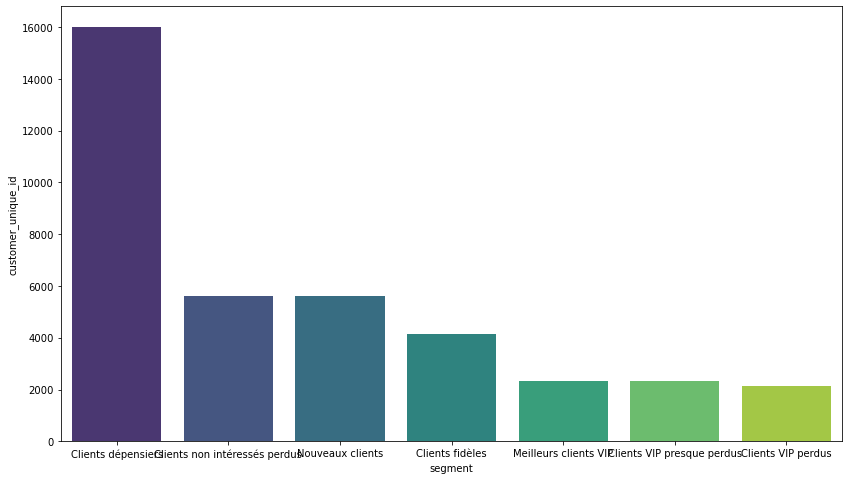

In [22]:
#Visualisation segmentation diagramme en barres
segmentation = df_rfm_segmentation.groupby('segment')['customer_unique_id'].nunique().sort_values(ascending = False).reset_index()
segmentation.drop([0], inplace = True) # Suppression ligne "Autres clients" 
# On ne garde que les clients identifiés dans les segments qui nous intéressent (VIP, perdus, presque perdus...)
plt.figure(figsize = (14,8))
sns.barplot(data = segmentation, x = 'segment', y = 'customer_unique_id', palette = 'viridis')

### <span class="bg-success"> 3.2 Visualisation : Squarify plot<span>

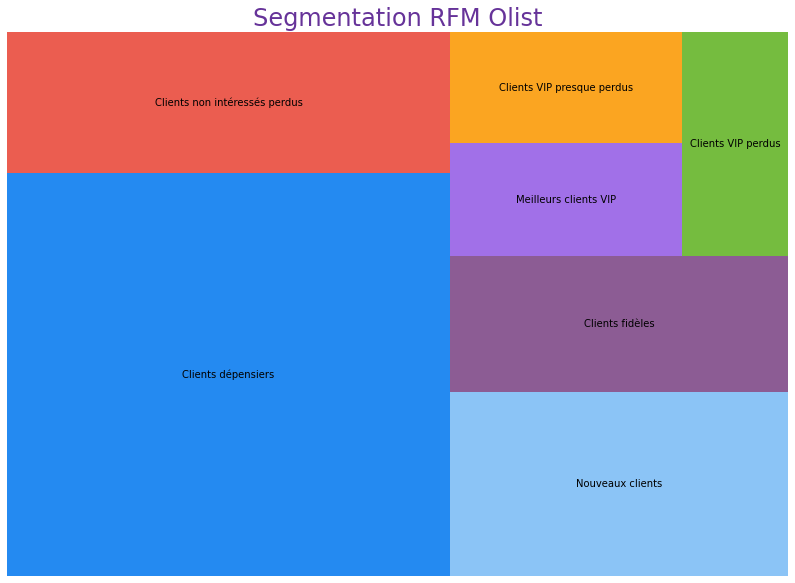

In [23]:
#Visualisation : squarify plot
# Manually Entering Colors
colors = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f"]
# min and max value
mini = min(segmentation['customer_unique_id']) 
maxi = max(segmentation['customer_unique_id']) 
# Trouver des couleurs pour chaque segment
norm = matplotlib.colors.Normalize(vmin = mini, vmax = maxi)
# Plotting
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14,10)
squarify.plot(sizes = segmentation['customer_unique_id'], label = segmentation.segment, alpha = 1, color = colors)
# Supprimer l'axe
plt.axis('off')
# Title
plt.title("Segmentation RFM Olist", fontsize=24, color="rebeccapurple")
# Title Positioning
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.show()

# <span class="bg-info"> 4. Stabilité de la clientèle sur 6 mois MARS à AOUT 2018<span>

In [24]:
df = pd.read_csv('data_clients_sankeys.csv')

In [25]:
df.head()

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score,geolocation_lat,geolocation_lng,récence,fréquence,valeur_monétaire,an_dernier_achat,mois_dernier_achat,jour_dernier_achat,heure_dernier_achat,jour_préféré_des_achats,nbre_articles,moy_nbre_articles,panier_moyen,payment_value_max,facilités_paiement,note_moy_avis,price_appliance,price_art_music_cinema_books,price_auto,price_baby,price_computer_electronic_telephony,price_construction_tools,price_cool_stuff,price_fashion_accessories,price_flowers,price_food_drink,price_home_furniture,price_hygien_beauty,price_industry_commerce_and_business,price_market_place,price_pet_shop,price_sports_leisure,price_stationery,price_toys,catégorie_+_achetée,moyen_paiement_prefere
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,2017-05-22 15:22:12,124.99,21.88,home_furniture,1.0,credit_card,2.0,146.87,4,-20.509897,-47.397866,470,1,146.87,2017,5,16,15,1,1,1.0,124.99,146.87,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,home_furniture,credit_card
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,2018-01-18 20:58:32,289.00,46.48,home_furniture,1.0,credit_card,8.0,335.48,5,-23.726853,-46.545746,229,1,335.48,2018,1,12,20,4,1,1.0,289.00,335.48,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,home_furniture,credit_card
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,bd07b66896d6f1494f5b86251848ced7,2018-06-05 16:19:10,139.94,17.79,home_furniture,1.0,credit_card,7.0,157.73,5,-23.527788,-46.660310,102,1,157.73,2018,5,19,16,5,1,1.0,139.94,157.73,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,home_furniture,credit_card
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,a5647c44af977b148e0a3a4751a09e2e,2018-03-27 16:31:16,149.94,23.36,home_furniture,1.0,credit_card,1.0,173.30,5,-23.496930,-46.185352,169,1,173.30,2018,3,13,16,1,1,1.0,149.94,173.30,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,home_furniture,credit_card
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1.0,9391a573abe00141c56e38d84d7d5b3b,2018-07-31 10:10:09,230.00,22.25,home_furniture,1.0,credit_card,8.0,252.25,5,-22.987222,-47.151073,32,1,252.25,2018,7,29,9,6,1,1.0,230.00,252.25,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,home_furniture,credit_card


## <span class="bg-success"> 4.1 Création des segments clients sur 6 mois<span>

### Segments clients 1 mois avant la fin de l'historique (30/07/18)

In [26]:
# Conversion de la colonne 'order_purchase_timestamp' au format datetime pour calculs ultérieurs
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# dataframe arrêté 1 mois avant la fin de l'historique
df_1 = df[df.order_purchase_timestamp <= '2018-07-30 15:00:37']

#Vérification min max historique
print('Min : {}, Max : {}'.format(min(df_1.order_purchase_timestamp), max(df_1.order_purchase_timestamp)))

#Date de référence fixée au lendemain de la dernière date enregistrée dans la table 
date_reference_1 = max(df_1.order_purchase_timestamp) + dt.timedelta(1)
print('date_reference_1 : {}'.format(date_reference_1))

#Table RFM 1 mois avant fin historique
df1_rfm = df_1.groupby('customer_unique_id').agg(
                                            {'order_purchase_timestamp' : lambda x: (date_reference_1 - x.max()).days, # Récence
                                             'order_id' : 'count', # Fréquence
                                             'payment_value' : 'sum'}   # Valeur monétaire
                                              )
df1_rfm.rename(columns={'order_purchase_timestamp': 'récence', 
                          'order_id': 'fréquence', 
                          'payment_value': 'valeur_monétaire'}, inplace=True)

#Détermination des quantiles
quantiles_1 = df1_rfm.quantile(q=[0.25,0.5,0.75])

df1_rfm['R_Quartile'] = df1_rfm['récence'].apply(RScore, args=('récence',quantiles_1))
df1_rfm['F_Quartile'] = df1_rfm['fréquence'].apply(FMScore, args=('fréquence', quantiles_1))
df1_rfm['M_Quartile'] = df1_rfm['valeur_monétaire'].apply(FMScore, args=('valeur_monétaire',quantiles_1))

#RFMScore
df1_rfm['RFMScore'] = df1_rfm.R_Quartile.map(str) + df1_rfm.F_Quartile.map(str) + df1_rfm.M_Quartile.map(str)

#Ajout de segments clients 
df1_rfm['segment1'] = ""
mask1 = df1_rfm['RFMScore'] == '111'# vip
mask2 = df1_rfm['RFMScore'] == '311'#clients vip presque perdus
mask3 = df1_rfm['RFMScore'] == '411'# clients vip perdus
mask4 = df1_rfm['RFMScore'] == '444'# clients non intéressés perdus
mask5 = df1_rfm['RFMScore'] == '144'# nouveaux clients
# Autres clients
mask6 = (df1_rfm['RFMScore'] != '444') & (df1_rfm['RFMScore'] != '411') & (df1_rfm['RFMScore'] != '311') & (df1_rfm['RFMScore'] != '111') & (df1_rfm['RFMScore'] != '144')
# Clients fidèles dans autres clients
mask7 = (df1_rfm['F_Quartile'] == 1) & (df1_rfm['RFMScore'] != '444') & (df1_rfm['RFMScore'] != '411') & (df1_rfm['RFMScore'] != '311') & (df1_rfm['RFMScore'] != '111') & (df1_rfm['RFMScore'] != '144')
# Clients dépensiers dans autres clients
mask8 = (df1_rfm['M_Quartile'] == 1) & (df1_rfm['RFMScore'] != '444') & (df1_rfm['RFMScore'] != '411') & (df1_rfm['RFMScore'] != '311') & (df1_rfm['RFMScore'] != '111') & (df1_rfm['RFMScore'] != '144')

df1_rfm.loc[mask1, 'segment1'] = 'Meilleurs clients VIP'
df1_rfm.loc[mask2, 'segment1'] = 'Clients VIP presque perdus'
df1_rfm.loc[mask3, 'segment1'] = 'Clients VIP perdus'
df1_rfm.loc[mask4, 'segment1'] = 'Clients non intéressés perdus'
df1_rfm.loc[mask5, 'segment1'] = 'Nouveaux clients'
df1_rfm.loc[mask6, 'segment1'] = 'Autres clients'
df1_rfm.loc[mask7, 'segment1'] = 'Clients fidèles'
df1_rfm.loc[mask8, 'segment1'] = 'Clients dépensiers'

df1_rfm.head();

Min : 2016-10-03 09:44:50, Max : 2018-07-30 14:57:33
date_reference_1 : 2018-07-31 14:57:33


In [27]:
#On garde les clients qui étaient dans la base de données en juillet
df1_rfm.reset_index(inplace = True)
df_rfm_segmentation = df_rfm_segmentation[df_rfm_segmentation.customer_unique_id.isin(df1_rfm.customer_unique_id)]
print(df_rfm_segmentation.shape)
print(df1_rfm.shape)

from sklearn import metrics
#Calcul ARI
ARI_rfm_1_mois = metrics.adjusted_rand_score(df_rfm_segmentation.RFMScore, df1_rfm.RFMScore)
print(ARI_rfm_1_mois)

#Ajout ARI dans le tableau de résultats
resultats_rfm = pd.DataFrame({})
resultats_rfm = resultats_rfm.append(pd.DataFrame({
    'Periode' : ['1 mois_Juillet_août'],
    'ARI' : [ARI_rfm_1_mois]}))
resultats_rfm

(84644, 9)
(84644, 9)
0.734341624818032


,Periode,ARI
0,1 mois_Juillet_août,0.734342


### Segments clients 3 mois avant la fin de l'historique (30/05/18)

In [28]:
# Conversion de la colonne 'order_purchase_timestamp' au format datetime pour calculs ultérieurs
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# dataframe arrêté 3 mois avant la fin de l'historique
df_3 = df[df.order_purchase_timestamp <= '2018-05-30 15:00:37']

#Vérification min max historique
print('Min : {}, Max : {}'.format(min(df_3.order_purchase_timestamp), max(df_3.order_purchase_timestamp)))

#Date de référence fixée au lendemain de la dernière date enregistrée dans la table 
date_reference_3 = max(df_3.order_purchase_timestamp) + dt.timedelta(1)
print('date_reference_3 : {}'.format(date_reference_3))

#Table RFM 3 mois avant fin historique
df3_rfm = df_3.groupby('customer_unique_id').agg(
                                            {'order_purchase_timestamp' : lambda x: (date_reference_3 - x.max()).days, # Récence
                                             'order_id' : 'count', # Fréquence
                                             'payment_value' : 'sum'}   # Valeur monétaire
                                              )
df3_rfm.rename(columns={'order_purchase_timestamp': 'récence', 
                          'order_id': 'fréquence', 
                          'payment_value': 'valeur_monétaire'}, inplace=True)

#Détermination des quantiles
quantiles_3 = df3_rfm.quantile(q=[0.25,0.5,0.75])

df3_rfm['R_Quartile'] = df3_rfm['récence'].apply(RScore, args=('récence',quantiles_3))
df3_rfm['F_Quartile'] = df3_rfm['fréquence'].apply(FMScore, args=('fréquence', quantiles_3))
df3_rfm['M_Quartile'] = df3_rfm['valeur_monétaire'].apply(FMScore, args=('valeur_monétaire',quantiles_3))

# RFMScore
df3_rfm['RFMScore'] = df3_rfm.R_Quartile.map(str) + df3_rfm.F_Quartile.map(str) + df3_rfm.M_Quartile.map(str)

#Ajout de segments clients 
df3_rfm['segment3'] = ""
mask1 = df3_rfm['RFMScore'] == '111'# vip
mask2 = df3_rfm['RFMScore'] == '311'#clients vip presque perdus
mask3 = df3_rfm['RFMScore'] == '411'# clients vip perdus
mask4 = df3_rfm['RFMScore'] == '444'# clients non intéressés perdus
mask5 = df3_rfm['RFMScore'] == '144'# nouveaux clients
# Autres clients
mask6 = (df3_rfm['RFMScore'] != '444') & (df3_rfm['RFMScore'] != '411') & (df3_rfm['RFMScore'] != '311') & (df3_rfm['RFMScore'] != '111') & (df3_rfm['RFMScore'] != '144')
# Clients fidèles dans autres clients
mask7 = (df3_rfm['F_Quartile'] == 1) & (df3_rfm['RFMScore'] != '444') & (df3_rfm['RFMScore'] != '411') & (df3_rfm['RFMScore'] != '311') & (df3_rfm['RFMScore'] != '111') & (df3_rfm['RFMScore'] != '144')
# Clients dépensiers dans autres clients
mask8 = (df3_rfm['M_Quartile'] == 1) & (df3_rfm['RFMScore'] != '444') & (df3_rfm['RFMScore'] != '411') & (df3_rfm['RFMScore'] != '311') & (df3_rfm['RFMScore'] != '111') & (df3_rfm['RFMScore'] != '144')

df3_rfm.loc[mask1, 'segment3'] = 'Meilleurs clients VIP'
df3_rfm.loc[mask2, 'segment3'] = 'Clients VIP presque perdus'
df3_rfm.loc[mask3, 'segment3'] = 'Clients VIP perdus'
df3_rfm.loc[mask4, 'segment3'] = 'Clients non intéressés perdus'
df3_rfm.loc[mask5, 'segment3'] = 'Nouveaux clients'
df3_rfm.loc[mask6, 'segment3'] = 'Autres clients'
df3_rfm.loc[mask7, 'segment3'] = 'Clients fidèles'
df3_rfm.loc[mask8, 'segment3'] = 'Clients dépensiers'

df3_rfm.head();

Min : 2016-10-03 09:44:50, Max : 2018-05-30 14:58:50
date_reference_3 : 2018-05-31 14:58:50


In [29]:
#On garde les clients qui étaient dans la base de données en mai
df3_rfm.reset_index(inplace = True)
df_rfm_segmentation = df_rfm_segmentation[df_rfm_segmentation.customer_unique_id.isin(df3_rfm.customer_unique_id)]
print(df_rfm_segmentation.shape)
print(df3_rfm.shape)

#Calcul ARI
ARI_rfm_3_mois = metrics.adjusted_rand_score(df_rfm_segmentation.RFMScore, df3_rfm.RFMScore)
print(ARI_rfm_3_mois)

#Ajout ARI dans le tableau de résultats
resultats_rfm = resultats_rfm.append(pd.DataFrame({
    'Periode' : ['3 mois_Mai_août'],
    'ARI' : [ARI_rfm_3_mois]}))
resultats_rfm

(73249, 9)
(73249, 9)
0.5638628949569655


,Periode,ARI
0,1 mois_Juillet_août,0.734342
0,3 mois_Mai_août,0.563863


### Segments clients 6 mois avant la fin de l'historique (01/03/18)

In [30]:
# Conversion de la colonne 'order_purchase_timestamp' au format datetime pour calculs ultérieurs
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# dataframe arrêté 6 mois avant la fin de l'historique
df_6 = df[df.order_purchase_timestamp <= '2018-02-28 15:00:37']

#Vérification min max historique
print('Min : {}, Max : {}'.format(min(df_6.order_purchase_timestamp), max(df_6.order_purchase_timestamp)))

#Date de référence fixée au lendemain de la dernière date enregistrée dans la table 
date_reference_6 = max(df_6.order_purchase_timestamp) + dt.timedelta(1)
print('date_reference_3 : {}'.format(date_reference_6))

#Table RFM 3 mois avant fin historique
df6_rfm = df_6.groupby('customer_unique_id').agg(
                                            {'order_purchase_timestamp' : lambda x: (date_reference_6 - x.max()).days, # Récence
                                             'order_id' : 'count', # Fréquence
                                             'payment_value' : 'sum'}   # Valeur monétaire
                                              )
df6_rfm.rename(columns={'order_purchase_timestamp': 'récence', 
                          'order_id': 'fréquence', 
                          'payment_value': 'valeur_monétaire'}, inplace=True)

#Détermination des quantiles
quantiles_6 = df6_rfm.quantile(q=[0.25,0.5,0.75])

df6_rfm['R_Quartile'] = df6_rfm['récence'].apply(RScore, args=('récence',quantiles_6))
df6_rfm['F_Quartile'] = df6_rfm['fréquence'].apply(FMScore, args=('fréquence', quantiles_6))
df6_rfm['M_Quartile'] = df6_rfm['valeur_monétaire'].apply(FMScore, args=('valeur_monétaire',quantiles_6))

# RFMScore
df6_rfm['RFMScore'] = df6_rfm.R_Quartile.map(str) + df6_rfm.F_Quartile.map(str) + df6_rfm.M_Quartile.map(str)

#Ajout de segments clients 
df6_rfm['segment6'] = ""
mask1 = df6_rfm['RFMScore'] == '111'# vip
mask2 = df6_rfm['RFMScore'] == '311'#clients vip presque perdus
mask3 = df6_rfm['RFMScore'] == '411'# clients vip perdus
mask4 = df6_rfm['RFMScore'] == '444'# clients non intéressés perdus
mask5 = df6_rfm['RFMScore'] == '144'# nouveaux clients
# Autres clients
mask6 = (df6_rfm['RFMScore'] != '444') & (df6_rfm['RFMScore'] != '411') & (df6_rfm['RFMScore'] != '311') & (df6_rfm['RFMScore'] != '111') & (df6_rfm['RFMScore'] != '144')
# Clients fidèles dans autres clients
mask7 = (df6_rfm['F_Quartile'] == 1) & (df6_rfm['RFMScore'] != '444') & (df6_rfm['RFMScore'] != '411') & (df6_rfm['RFMScore'] != '311') & (df6_rfm['RFMScore'] != '111') & (df6_rfm['RFMScore'] != '144')
# Clients dépensiers dans autres clients
mask8 = (df6_rfm['M_Quartile'] == 1) & (df6_rfm['RFMScore'] != '444') & (df6_rfm['RFMScore'] != '411') & (df6_rfm['RFMScore'] != '311') & (df6_rfm['RFMScore'] != '111') & (df6_rfm['RFMScore'] != '144')

df6_rfm.loc[mask1, 'segment6'] = 'Meilleurs clients VIP'
df6_rfm.loc[mask2, 'segment6'] = 'Clients VIP presque perdus'
df6_rfm.loc[mask3, 'segment6'] = 'Clients VIP perdus'
df6_rfm.loc[mask4, 'segment6'] = 'Clients non intéressés perdus'
df6_rfm.loc[mask5, 'segment6'] = 'Nouveaux clients'
df6_rfm.loc[mask6, 'segment6'] = 'Autres clients'
df6_rfm.loc[mask7, 'segment6'] = 'Clients fidèles'
df6_rfm.loc[mask8, 'segment6'] = 'Clients dépensiers'

df6_rfm.head();

Min : 2016-10-03 09:44:50, Max : 2018-02-28 14:57:20
date_reference_3 : 2018-03-01 14:57:20


In [31]:
#On garde les clients qui étaient dans la base de données en mars
df6_rfm.reset_index(inplace = True)
df_rfm_segmentation = df_rfm_segmentation[df_rfm_segmentation.customer_unique_id.isin(df6_rfm.customer_unique_id)]
print(df_rfm_segmentation.shape)
print(df6_rfm.shape)

#Calcul ARI
ARI_rfm_6_mois = metrics.adjusted_rand_score(df_rfm_segmentation.RFMScore, df6_rfm.RFMScore)
print(ARI_rfm_6_mois)

#Ajout ARI dans le tableau de résultats
resultats_rfm = resultats_rfm.append(pd.DataFrame({
    'Periode' : ['6 mois_Mars_août'],
    'ARI' : [ARI_rfm_6_mois]}))
resultats_rfm

(53844, 9)
(53844, 9)
0.5483649946846604


,Periode,ARI
0,1 mois_Juillet_août,0.734342
0,3 mois_Mai_août,0.563863
0,6 mois_Mars_août,0.548365


In [32]:
# Table RFM à la fin de l'historique (30/07/18)
df_rfm = pd.read_csv('data_rfm_olist.csv')
df_rfm.drop('Unnamed: 0', axis = 1, inplace = True)

In [33]:
#Table RFM 6 mois, 3 mois, 1 mois, jusqu'à la fin de l'historique
df_sankey_1 = pd.merge(df_rfm, df1_rfm, on = 'customer_unique_id', how = 'left')
df_sankey_2 = pd.merge(df_sankey_1, df3_rfm, on = 'customer_unique_id', how = 'left')
df_sankey_3 = pd.merge(df_sankey_2, df6_rfm, on = 'customer_unique_id', how = 'left')
#Création table pour visualisation segments clients
colonnes = ['customer_unique_id','segment6', 'segment3', 'segment1', 'segment']
df_sankey = df_sankey_3[colonnes]
df_sankey.head()

,customer_unique_id,segment6,segment3,segment1,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,NaN,Autres clients,Autres clients,Autres clients
1,0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,Nouveaux clients,Nouveaux clients,Autres clients
2,0000f46a3911fa3c0805444483337064,Autres clients,Autres clients,Autres clients,Autres clients
3,0000f6ccb0745a6a4b88665a16c9f078,Autres clients,Autres clients,Autres clients,Autres clients
4,0004aac84e0df4da2b147fca70cf8255,Autres clients,Autres clients,Autres clients,Autres clients


In [34]:
# Créer la table pour tracer le Sankey diagram
#1 mois
df_sankey_1seg = df_sankey.groupby(by = ['segment1', 'segment']).agg({'segment' : 'count'})
df_sankey_1seg.rename(columns={'segment' : 'value_1'}, inplace=True)
df_sankey_1 = df_sankey_1seg.reset_index()
#3 mois
df_sankey_2seg = df_sankey.groupby(by = ['segment3', 'segment']).agg({'segment' : 'count'})
df_sankey_2seg.rename(columns={'segment' : 'value_2'}, inplace=True)
df_sankey_2 = df_sankey_2seg.reset_index()
#6 mois
df_sankey_3seg = df_sankey.groupby(by = ['segment6', 'segment']).agg({'segment' : 'count'})
df_sankey_3seg.rename(columns={'segment' : 'value_3'}, inplace=True)
df_sankey_3 = df_sankey_3seg.reset_index()

## <span class="bg-success"> 4.2 Visualisation : Sankey Diagrams<span>

Le diagramme de Sankey est une forme d'organigramme dans lequel la largeur des flèches de débit est proportionnelle à la quantité de débit. C'est un outil visuel parfait pour visualiser la répartition entre un pot initial et des pots plus petits suivants. 

### <span class="bg-warning"> 4.2.1 Stabilité sur 1 mois : juillet 18 à août 18<span>
    
__Vue d'ensemble de tous les segments clients__

In [35]:
#Sankey vue d'ensemble
source = [0, 0, 0,        # Autres clients
          1, 1, 1,        # Clients VIP perdus  
          2, 2, 2, 2,     # Clients VIP presque perdus
          3, 3, 3, 3,     # Clients dépensiers 
          4, 4, 4, 4, 4,  # Clients fidèles 
          5, 5,           # Clients non intéressés perdus
          6, 6, 6,        # Meilleurs clients VIP    
          7, 7]           # Nouveaux clients

target = [ 32, 29, 28,
          22, 30 , 31,
          22, 23, 30, 31,
          23, 29, 30, 31,
          22, 23, 29, 30, 31,
          32, 28,
          29, 30, 31,
          32, 33]         

value = [48613, 1256, 358,
         1942, 316, 19,
         146, 2016, 316, 15,
         306, 13327, 333, 18, 
         46, 46, 52, 3124, 46, 
         157, 5182,
         486, 313, 1759,
         1214, 3886]

label = ['Autres clients',#0
         'Clients VIP perdus', #1
         'Clients VIP presque perdus',#2
         'Clients dépensiers',#3
         'Clients fidèles', #4
         'Clients non intéressés perdus',#5
         'Meilleurs clients VIP', #6
         'Nouveaux clients',#7
         
         'Autres clients',#32                  # Autres clients
         'Clients dépensiers',#29
         'Clients non intéressés perdus',#28
         
         'Clients VIP perdus', #22            # Clients VIP perdus
         'Clients fidèles',#30 
         'Meilleurs clients VIP',#31
         
         'Clients VIP perdus', #22            # Clients VIP presque perdus
         'Clients VIP presque perdus',#23
         'Clients fidèles',#30
         'Meilleurs clients VIP', #31
         
         'Clients VIP presque perdus',#23    # Clients dépensiers
         'Clients dépensiers',#29
         'Clients fidèles',#30
         'Meilleurs clients VIP',#31
         
         'Clients VIP perdus', #22            # Clients fidèles
         'Clients VIP presque perdus',#23 
         'Clients dépensiers',#29
         'Clients fidèles',#30
         'Meilleurs clients VIP',#31
         
         'Autres clients',#32                  # Clients non intéressés perdus
         'Clients non intéressés perdus',#28
                     
         'Clients dépensiers',#29             # Meilleurs clients VIP
         'Clients fidèles',#30
         'Meilleurs clients VIP',#31
         
         'Autres clients',#32
         'Nouveaux clients',#33               # Nouveaux clients
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7',
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#8FF9FF', '#8FF9FF',
              '#FFE18F', '#FFE18F', '#FFE18F', 
              '#B6BAF5', '#B6BAF5']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle OLIST --- JUILLET à AOUT 18 --- 1 mois",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

__Visualisation du groupe des meilleurs clients stabilité sur 1 mois__

In [36]:
#Sankey meilleurs clients 1 mois
node_label = ['Meilleurs clients VIP', 'Meilleurs clients VIP ', 'Clients dépensiers','Clients fidèles']
node_dict = {y:x for x, y in enumerate(node_label)}
node_dict

source = ['Meilleurs clients VIP', 'Meilleurs clients VIP','Meilleurs clients VIP', 'Meilleurs clients VIP']
target = ['Meilleurs clients VIP ', 'Clients dépensiers','Clients fidèles'] 
values = [ 1759 , 486, 313]

source_node = [node_dict[x] for x in source]
target_node = [node_dict[x] for x in target]

# link data
color_link = ['#FF90A1','#A6E3D7', '#CBB4D5'] # rouge, vert, violet
# Node data
color_node = ['#D1D0C9','#D1D0C9', '#D1D0C9', '#D1D0C9'] # gris clair

fig = go.Figure(
    data=[go.Sankey(
        node = dict(
            label = node_label,
            color = color_node
        ),
        link = dict(
            source = source_node,
            target = target_node,
            value = values,
            color = color_link
        ))])
fig.update_layout(
    hovermode = 'x',
    title="Stabilité meilleurs clients OLIST sur 1 mois",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958')

plot(fig,
     image_filename='sankey_plot_1', 
     image='png', 
     image_width=1000, 
     image_height=600    
)
fig.show()

### <span class="bg-warning"> 4.2.2 Stabilité sur 3 mois : mai 18 à août 18<span>
    
__Vue d'ensemble de tous les segments clients__

In [37]:
#Sankey vue d'ensemble
source = [0, 0, 0,        # Autres clients
          1, 1, 1,        # Clients VIP perdus  
          2, 2, 2, 2,     # Clients VIP presque perdus
          3, 3, 3, 3,     # Clients dépensiers 
          4, 4, 4, 4, 4,  # Clients fidèles 
          5, 5,           # Clients non intéressés perdus
          6, 6, 6,        # Meilleurs clients VIP    
          7, 7]           # Nouveaux clients

target = [ 32, 29, 28,
          22, 30 , 31,
          22, 23, 30, 31,
          23, 29, 30, 31,
          22, 23, 29, 30, 31,
          32, 28,
          29, 30, 31,
          32, 33]         

value = [41183, 1092, 1030,
         1655, 280, 45,
         433, 1452, 275, 52,
         870, 10826, 279, 57, 
         46, 46, 52, 2803, 53, 
         128, 4510,
         1320, 289, 617,
         3283, 1122]

label = ['Autres clients',#0
         'Clients VIP perdus', #1
         'Clients VIP presque perdus',#2
         'Clients dépensiers',#3
         'Clients fidèles', #4
         'Clients non intéressés perdus',#5
         'Meilleurs clients VIP', #6
         'Nouveaux clients',#7
         
         'Autres clients',#32                  # Autres clients
         'Clients dépensiers',#29
         'Clients non intéressés perdus',#28
         
         'Clients VIP perdus', #22            # Clients VIP perdus
         'Clients fidèles',#30 
         'Meilleurs clients VIP',#31
         
         'Clients VIP perdus', #22            # Clients VIP presque perdus
         'Clients VIP presque perdus',#23
         'Clients fidèles',#30
         'Meilleurs clients VIP', #31
         
         'Clients VIP presque perdus',#23    # Clients dépensiers
         'Clients dépensiers',#29
         'Clients fidèles',#30
         'Meilleurs clients VIP',#31
         
         'Clients VIP perdus', #22            # Clients fidèles
         'Clients VIP presque perdus',#23 
         'Clients dépensiers',#29
         'Clients fidèles',#30
         'Meilleurs clients VIP',#31
         
         'Autres clients',#32                  # Clients non intéressés perdus
         'Clients non intéressés perdus',#28
                     
         'Clients dépensiers',#29             # Meilleurs clients VIP
         'Clients fidèles',#30
         'Meilleurs clients VIP',#31
         
         'Autres clients',#32
         'Nouveaux clients',#33               # Nouveaux clients
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7',
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#8FF9FF', '#8FF9FF',
              '#FFE18F', '#FFE18F', '#FFE18F', 
              '#B6BAF5', '#B6BAF5']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle OLIST --- MAI à AOUT 18 --- 3 mois",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

__Visualisation du groupe des meilleurs clients stabilité sur 3 mois__

In [38]:
#Sankey meilleurs clients 3 mois
node_label = ['Meilleurs clients VIP', 'Meilleurs clients VIP ', 'Clients dépensiers','Clients fidèles']
node_dict = {y:x for x, y in enumerate(node_label)}
node_dict

source = ['Meilleurs clients VIP', 'Meilleurs clients VIP','Meilleurs clients VIP']
target = ['Meilleurs clients VIP ', 'Clients dépensiers', 'Clients fidèles'] 
values = [ 617, 1320, 289]

source_node = [node_dict[x] for x in source]
target_node = [node_dict[x] for x in target]

# link data
color_link = ['#FF90A1','#A6E3D7', '#CBB4D5'] # rouge, vert, violet
# Node data
color_node = ['#D1D0C9','#D1D0C9', '#D1D0C9', '#D1D0C9'] # gris clair

fig = go.Figure(
    data=[go.Sankey(
        node = dict(
            label = node_label,
            color = color_node
        ),
        link = dict(
            source = source_node,
            target = target_node,
            value = values,
            color = color_link
        ))])
fig.update_layout(
    hovermode = 'x',
    title="Stabilité meilleurs clients OLIST sur 3 mois",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958')

plot(fig,
     image_filename='sankey_plot_1', 
     image='png', 
     image_width=1000, 
     image_height=600    
)
fig.show()

### <span class="bg-warning"> 4.2.3 Stabilité sur 6 mois : mars 18 à août 18<span>

__Vue d'ensemble de tous les segments clients__

In [39]:
#Sankey vue d'ensemble
source = [0, 0, 0,        # Autres clients
          1, 1, 1, 1,     # Clients VIP perdus  
          2, 2, 2, 2, 2,  # Clients VIP presque perdus
          3, 3, 3, 3,     # Clients dépensiers 
          4, 4, 4, 4, 4,  # Clients fidèles 
          5, 5,           # Clients non intéressés perdus
          6, 6, 6, 6,     # Meilleurs clients VIP    
          7]              # Nouveaux clients

target = [35, 32, 30,
          24, 32 , 33, 34,
          24, 31, 32, 33, 34,
          31, 32, 33, 34,
          24, 31, 32, 33, 34,
          35, 30,
          31, 32, 33, 34,
          35]         

value = [28331, 807, 2216,
         1172, 23, 204, 41,
         916, 389, 25, 227, 53,
         1396, 7165, 201, 45, 
         46, 48, 48, 2189, 36, 
         67, 3324,
         535, 886, 221, 60, 
         3563]

label = ['Autres clients',#0
         'Clients VIP perdus', #1
         'Clients VIP presque perdus',#2
         'Clients dépensiers',#3
         'Clients fidèles', #4
         'Clients non intéressés perdus',#5
         'Meilleurs clients VIP', #6
         'Nouveaux clients',#7
         
         'Autres clients',#35                 # Autres clients
         'Clients dépensiers',#32
         'Clients non intéressés perdus',#30
         
         'Clients VIP perdus', #24            # Clients VIP perdus
         'Clients dépensiers',#32
         'Clients fidèles',#33 
         'Meilleurs clients VIP',#34
         
         'Clients VIP perdus', #24            # Clients VIP presque perdus
         'Clients VIP presque perdus',#31
         'Clients dépensiers',#32
         'Clients fidèles',#33
         'Meilleurs clients VIP', #34
         
         'Clients VIP presque perdus',#31     # Clients dépensiers
         'Clients dépensiers',#32
         'Clients fidèles',#33
         'Meilleurs clients VIP',#34
         
         'Clients VIP perdus', #24            # Clients fidèles
         'Clients VIP presque perdus',#31 
         'Clients dépensiers',#32
         'Clients fidèles',#33
         'Meilleurs clients VIP',#34
         
         'Autres clients',#35                  # Clients non intéressés perdus
         'Clients non intéressés perdus',#30
                     
         'Clients VIP presque perdus',#31
         'Clients dépensiers',#32             # Meilleurs clients VIP
         'Clients fidèles',#33
         'Meilleurs clients VIP',#34
         
         'Autres clients',#35                # Nouveaux clients
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7',
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#8FF9FF', '#8FF9FF',
              '#FFE18F', '#FFE18F', '#FFE18F', '#FFE18F',
              '#B6BAF5']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle OLIST --- FEVRIER à AOUT 18 --- 6 mois",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

__Visualisation du segment des meilleurs clients : stabilité sur 6 mois__

In [40]:
#Sankey meilleurs clients
node_label = ['Meilleurs clients VIP', 'Meilleurs clients VIP ', 'Clients VIP presque perdus','Clients dépensiers','Clients fidèles']
node_dict = {y:x for x, y in enumerate(node_label)}
node_dict

source = ['Meilleurs clients VIP', 'Meilleurs clients VIP','Meilleurs clients VIP', 'Meilleurs clients VIP']
target = ['Meilleurs clients VIP ', 'Clients VIP presque perdus','Clients dépensiers','Clients fidèles'] 
values = [ 60, 535, 886, 221]

source_node = [node_dict[x] for x in source]
target_node = [node_dict[x] for x in target]

# link data
color_link = ['#FF90A1','#A6E3D7', '#CBB4D5', '#FFEE8F'] # rouge, vert, violet, jaune
# Node data
color_node = ['#D1D0C9','#D1D0C9', '#D1D0C9', '#D1D0C9', '#D1D0C9'] # gris clair

fig = go.Figure(
    data=[go.Sankey(
        node = dict(
            label = node_label,
            color = color_node
        ),
        link = dict(
            source = source_node,
            target = target_node,
            value = values,
            color = color_link
        ))])
fig.update_layout(
    hovermode = 'x',
    title="Stabilité meilleurs clients OLIST sur 6 mois",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958')

plot(fig,
     image_filename='sankey_plot_1', 
     image='png', 
     image_width=1000, 
     image_height=600    
)
fig.show()

### <span class="bg-warning"> 4.2.4 Stabilité par morceaux : PARTIE 1. De mars à mai 18<span>

In [41]:
#Sankey vue d'ensemble
source = [0, 0, 0,        # Autres clients
          1, 1, 1,        # Clients VIP perdus  
          2, 2, 2, 2,     # Clients VIP presque perdus
          3, 3, 3,        # Clients dépensiers 
          4, 4, 4, 4, 4,  # Clients fidèles 
          5,              # Clients non intéressés perdus
          6, 6,           # Meilleurs clients VIP    
          7]              # Nouveaux clients

target = [29, 27, 26,
          21, 27 ,28,
          21, 22, 27, 28,
          22, 27, 28,
          21, 22, 27, 24, 28,
          26,
          27, 28,
          29]         

value = [30089, 18, 1247,
         1398, 4, 38,
         581, 980, 4, 45,
         1229, 7531, 47, 
         1, 3, 12, 2246, 105, 
         3391,
         1612, 90, 
         3563]

label = ['Autres clients',#0
         'Clients VIP perdus', #1
         'Clients VIP presque perdus',#2
         'Clients dépensiers',#3
         'Clients fidèles', #4
         'Clients non intéressés perdus',#5
         'Meilleurs clients VIP', #6
         'Nouveaux clients',#7
         
         'Autres clients',#29                 # Autres clients
         'Clients dépensiers',#27
         'Clients non intéressés perdus',#26
         
         'Clients VIP perdus', #21           # Clients VIP perdus
         'Clients dépensiers',#27
         'Meilleurs clients VIP',#28
         
         'Clients VIP perdus', #21           # Clients VIP presque perdus
         'Clients VIP presque perdus',#22
         'Clients dépensiers',#27
         'Meilleurs clients VIP', #28
         
         'Clients VIP presque perdus',#22     # Clients dépensiers
         'Clients dépensiers',#27
         'Meilleurs clients VIP',#28
         
         'Clients VIP perdus', #21            # Clients fidèles
         'Clients VIP presque perdus',#22 
         'Clients dépensiers',#27
         'Clients fidèles',#24
         'Meilleurs clients VIP',#28
                          
         'Clients non intéressés perdus',#26  # Clients non intéressés perdus
                     
         'Clients dépensiers',#27             # Meilleurs clients VIP
         'Meilleurs clients VIP',#28
         
         'Autres clients',#29                 # Nouveaux clients
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#CBB4D5', '#CBB4D5', '#CBB4D5', 
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#8FF9FF', 
              '#FFE18F', '#FFE18F', 
              '#B6BAF5']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle OLIST --- MARS à MAI 18 --- PARTIE 1",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

### <span class="bg-warning"> 4.2.5 Stabilité par morceaux : PARTIE 2. De mai à juillet 18<span>

In [42]:
#Sankey vue d'ensemble
source = [0, 0, 0, 0,       # Autres clients
          1, 1,             # Clients VIP perdus  
          2, 2, 2,          # Clients VIP presque perdus
          3, 3, 3,          # Clients dépensiers 
          4, 4,             # Clients fidèles 
          5,                # Clients non intéressés perdus
          6, 6,             # Meilleurs clients VIP    
          7, 7]             # Nouveaux clients

target = [25, 23, 22, 26,
          14, 24,
          14, 17, 24,
          17, 23, 24,
          20, 24,
          22,
          23, 24,
          25, 26]         

value = [42559, 42, 701, 3,
         1948, 32,
         329, 1839, 44,
         654, 11332, 46, 
         2913, 87,  
         4638,
         985, 1241, 
         2139, 2266]

label = ['Autres clients',#0
         'Clients VIP perdu', #1
         'Clients VIP presque perdus',#2
         'Clients dépensiers',#3
         'Clients fidèles', #4
         'Clients non intéressés perdus',#5
         'Meilleurs clients VIP', #6
         'Nouveaux clients',#7
         
         'Autres clients',#25                 # Autres clients
         'Clients dépensiers',#23
         'Clients non intéressés perdus',#22
         'Nouveaux clients',#26
         
         'Clients VIP perdus', #14           # Clients VIP perdus
         'Meilleurs clients VIP',#24
         
         'Clients VIP perdus', #14          # Clients VIP presque perdus
         'Clients VIP presque perdus',#17
         'Meilleurs clients VIP', #24
         
         'Clients VIP presque perdus',#17     # Clients dépensiers
         'Clients dépensiers',#23
         'Meilleurs clients VIP',#24
                
         'Clients fidèles',#20                # Clients fidèles
         'Meilleurs clients VIP',#24
                          
         'Clients non intéressés perdus',#22  # Clients non intéressés perdus
                     
         'Clients dépensiers',#23            # Meilleurs clients VIP
         'Meilleurs clients VIP',#24
         
         'Autres clients',#25                 # Nouveaux clients
         'Nouveaux clients'#26
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', '#A6E3D7',
              '#EBBAB5', '#EBBAB5',  
              '#FEF3C7', '#FEF3C7', '#FEF3C7',  
              '#CBB4D5', '#CBB4D5', '#CBB4D5', 
              '#FF90A1', '#FF90A1', 
              '#8FF9FF', 
              '#FFE18F', '#FFE18F', 
              '#B6BAF5', '#B6BAF5']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle OLIST --- MAI à JUILLET 18 --- PARTIE 2",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

### <span class="bg-warning"> 4.2.6 Stabilité par morceaux : 3. VUE D'ENSEMBLE de mars à août 18 <span>

In [43]:
#Sankey vue d'ensemble
source = [0, 0, 0,        # Autres clients
          1, 1, 1,        # Clients VIP perdus  
          2, 2, 2, 2,     # Clients VIP presque perdus
          3, 3, 3,        # Clients dépensiers 
          4, 4, 4, 4, 4,  # Clients fidèles 
          5,              # Clients non intéressés perdus
          6, 6,           # Meilleurs clients VIP    
          7,              # Nouveaux clients
          
          29, 29, 29, 29,       # Autres clients
          21, 21,               # Clients VIP perdus  
          22, 22, 22,           # Clients VIP presque perdus
          27, 27, 27,           # Clients dépensiers 
          24, 24,               # Clients fidèles 
          26,                   # Clients non intéressés perdus
          28, 28,               # Meilleurs clients VIP    
          30, 30,               # Nouveaux clients
          
          48, 48, 48,                  # Autres clients
          37, 37, 37,                  # Clients VIP perdus  
          40, 40, 40, 40,              # Clients VIP presque perdus
          46, 46, 46, 46,              # Clients dépensiers 
          43, 43, 43, 43, 43,          # Clients fidèles 
          45, 45,                      # Clients non intéressés perdus
          47, 47, 47,                  # Meilleurs clients VIP    
          49, 49]                      # Nouveaux clients
          

target = [29, 27, 26,
          21, 27 ,28,
          21, 22, 27, 28,
          22, 27, 28,
          21, 22, 27, 24, 28,
          26,
          27, 28,
          29,
          
          48, 46, 45, 49,
          37, 47,
          37, 40, 47,
          40, 46, 47,
          43, 47,
          45,
          46, 47,
          48, 49,
          
          74, 71, 70,
          64, 72, 73,
          64, 65, 72, 73,
          65, 71, 72, 73,
          64, 65, 71, 72, 73,
          74, 70,
          71, 72, 73,
          74, 75]
                  

value = [30089, 18, 1247,
         1398, 4, 38,
         581, 980, 4, 45,
         1229, 7531, 47, 
         1, 3, 12, 2246, 105, 
         3391,
         1612, 90, 
         3563,
         42559, 42, 701, 3,
         1948, 32,
         329, 1839, 44,
         654, 11332, 46, 
         2913, 87,  
         4638,
         985, 1241, 
         2139, 2266,
         48613, 1256, 358,
         1942, 316, 19,
         146, 2016, 316, 15,
         306, 13327, 333, 18, 
         46, 46, 52, 3124, 46, 
         157, 5182,
         486, 313, 1759,
         1214, 3886]


label = [
    
# Partie 1 mars à mai
    
         'Autres clients',#0
         'Clients VIP perdus', #1
         'Clients VIP presque perdus',#2
         'Clients dépensiers',#3
         'Clients fidèles', #4
         'Clients non intéressés perdus',#5
         'Meilleurs clients VIP', #6
         'Nouveaux clients',#7
         
         'Autres clients',#29                 # Autres clients
         'Clients dépensiers',#27
         'Clients non intéressés perdus',#26
         
         'Clients VIP perdus', #21           # Clients VIP perdus
         'Clients dépensiers',#27
         'Meilleurs clients VIP',#28
         
         'Clients VIP perdus', #21           # Clients VIP presque perdus
         'Clients VIP presque perdus',#22
         'Clients dépensiers',#27
         'Meilleurs clients VIP', #28
         
         'Clients VIP presque perdus',#22     # Clients dépensiers
         'Clients dépensiers',#27
         'Meilleurs clients VIP',#28
         
         'Clients VIP perdus', #21            # Clients fidèles
         'Clients VIP presque perdus',#22 
         'Clients dépensiers',#27
         'Clients fidèles',#24
         'Meilleurs clients VIP',#28
                          
         'Clients non intéressés perdus',#26  # Clients non intéressés perdus
                     
         'Clients dépensiers',#27             # Meilleurs clients VIP
         'Meilleurs clients VIP',#28
         
         'Autres clients',#29                 # Nouveaux clients
    

# Partie 2 mai à juillet 
         
         #'Autres clients',
         #'Clients VIP perdu', 
         #'Clients VIP presque perdus',
         #'Clients dépensiers',
         #'Clients fidèles', 
         #'Clients non intéressés perdus',
         #'Meilleurs clients VIP', 
         'Nouveaux clients',#30
    
         'Autres clients',#48                 # Autres clients
         'Clients dépensiers',#46
         'Clients non intéressés perdus',#45
         'Nouveaux clients',#49
         
         'Clients VIP perdus', #37           # Clients VIP perdus
         'Meilleurs clients VIP',#47
         
         'Clients VIP perdus', #37          # Clients VIP presque perdus
         'Clients VIP presque perdus',#40
         'Meilleurs clients VIP', #47
         
         'Clients VIP presque perdus',#40     # Clients dépensiers
         'Clients dépensiers',#46
         'Meilleurs clients VIP',#47
                
         'Clients fidèles',#43                # Clients fidèles
         'Meilleurs clients VIP',#47
                          
         'Clients non intéressés perdus',#45  # Clients non intéressés perdus
                     
         'Clients dépensiers',#46            # Meilleurs clients VIP
         'Meilleurs clients VIP',#47
         
         'Autres clients',#48                 # Nouveaux clients
         'Nouveaux clients',#49
    
# Partie 3 juillet à août    
         
         #'Autres clients',#57
         #'Clients VIP perdus', #58
         #'Clients VIP presque perdus',#59
         #'Clients dépensiers',#60
         #'Clients fidèles', #61
         #'Clients non intéressés perdus',#62
         #"'Meilleurs clients VIP', #63
         #'Nouveaux clients',#64  
    
         
         'Autres clients',#74                  # Autres clients
         'Clients dépensiers',#71
         'Clients non intéressés perdus',#70
         
         'Clients VIP perdus', #64           # Clients VIP perdus
         'Clients fidèles',#72 
         'Meilleurs clients VIP',#73
         
         'Clients VIP perdus', #64            # Clients VIP presque perdus
         'Clients VIP presque perdus',#65
         'Clients fidèles',#72
         'Meilleurs clients VIP', #73
         
         'Clients VIP presque perdus',#65    # Clients dépensiers
         'Clients dépensiers',#71
         'Clients fidèles',#72
         'Meilleurs clients VIP',#73
         
         'Clients VIP perdus', #64            # Clients fidèles
         'Clients VIP presque perdus',#65 
         'Clients dépensiers',#71
         'Clients fidèles',#72
         'Meilleurs clients VIP',#73
         
         'Autres clients',#74                  # Clients non intéressés perdus
         'Clients non intéressés perdus',#70
                     
         'Clients dépensiers',#71             # Meilleurs clients VIP
         'Clients fidèles',#72
         'Meilleurs clients VIP',#73
         
         'Autres clients',#74
         'Nouveaux clients',#75               # Nouveaux clients
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', 
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#CBB4D5', '#CBB4D5', '#CBB4D5', 
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#8FF9FF', 
              '#FFE18F', '#FFE18F', 
              '#B6BAF5',
              
              '#A6E3D7', '#A6E3D7', '#A6E3D7', '#A6E3D7',
              '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7',  
              '#CBB4D5', '#CBB4D5', '#CBB4D5', 
              '#FF90A1', '#FF90A1', 
              '#8FF9FF', 
              '#FFE18F', '#FFE18F', 
              '#B6BAF5', '#B6BAF5',
             
              '#A6E3D7', '#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#8FF9FF', '#8FF9FF',
              '#FFE18F', '#FFE18F', '#FFE18F',
              '#B6BAF5', '#B6BAF5'
             ]

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle OLIST --- MARS à AOUT 18 --- VUE D'ENSEMBLE",
    font=dict(size = 12, color = 'white'),
    paper_bgcolor='#5B5958')
plot(fig,
     image_filename='sankey_total', 
     image='png', 
     image_width=1000, 
     image_height=600    
)
fig.show()

### <span class="bg-warning"> 4.2.7 Stabilité VIP par morceaux : VUE D'ENSEMBLE de mars à août 18 <span>

In [44]:
# Conversion de la colonne 'order_purchase_timestamp' au format datetime pour calculs ultérieurs
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# dataframe arrêté en juin 2018
df_juin = df[df.order_purchase_timestamp <= '2018-06-30 15:00:37']

#Vérification min max historique
print('Min : {}, Max : {}'.format(min(df_juin.order_purchase_timestamp), max(df_juin.order_purchase_timestamp)))

#Date de référence fixée au lendemain de la dernière date enregistrée dans la table 
date_reference_juin = max(df_juin.order_purchase_timestamp) + dt.timedelta(1)
print('date_reference_3 : {}'.format(date_reference_juin))

#Table RFM juin 2018 
dfjuin_rfm = df_juin.groupby('customer_unique_id').agg(
                                            {'order_purchase_timestamp' : lambda x: (date_reference_juin - x.max()).days, # Récence
                                             'order_id' : 'count', # Fréquence
                                             'payment_value' : 'sum'}   # Valeur monétaire
                                              )
dfjuin_rfm.rename(columns={'order_purchase_timestamp': 'récence', 
                          'order_id': 'fréquence', 
                          'payment_value': 'valeur_monétaire'}, inplace=True)

#Détermination des quantiles
quantiles_juin = dfjuin_rfm.quantile(q=[0.25,0.5,0.75])

dfjuin_rfm['R_Quartile'] = dfjuin_rfm['récence'].apply(RScore, args=('récence',quantiles_juin))
dfjuin_rfm['F_Quartile'] = dfjuin_rfm['fréquence'].apply(FMScore, args=('fréquence', quantiles_juin))
dfjuin_rfm['M_Quartile'] = dfjuin_rfm['valeur_monétaire'].apply(FMScore, args=('valeur_monétaire',quantiles_juin))

# RFMScore
dfjuin_rfm['RFMScore'] = dfjuin_rfm.R_Quartile.map(str) + dfjuin_rfm.F_Quartile.map(str) + dfjuin_rfm.M_Quartile.map(str)

#Ajout de segments clients 
dfjuin_rfm['segmentJuin'] = ""
mask1 = dfjuin_rfm['RFMScore'] == '111'# vip
mask2 = dfjuin_rfm['RFMScore'] == '311'#clients vip presque perdus
mask3 = dfjuin_rfm['RFMScore'] == '411'# clients vip perdus
mask4 = dfjuin_rfm['RFMScore'] == '444'# clients non intéressés perdus
mask5 = dfjuin_rfm['RFMScore'] == '144'# nouveaux clients
# Autres clients
mask6 = (dfjuin_rfm['RFMScore'] != '444') & (dfjuin_rfm['RFMScore'] != '411') & (dfjuin_rfm['RFMScore'] != '311') & (dfjuin_rfm['RFMScore'] != '111') & (dfjuin_rfm['RFMScore'] != '144')
# Clients fidèles dans autres clients
mask7 = (dfjuin_rfm['F_Quartile'] == 1) & (dfjuin_rfm['RFMScore'] != '444') & (dfjuin_rfm['RFMScore'] != '411') & (dfjuin_rfm['RFMScore'] != '311') & (dfjuin_rfm['RFMScore'] != '111') & (dfjuin_rfm['RFMScore'] != '144')
# Clients dépensiers dans autres clients
mask8 = (dfjuin_rfm['M_Quartile'] == 1) & (dfjuin_rfm['RFMScore'] != '444') & (dfjuin_rfm['RFMScore'] != '411') & (dfjuin_rfm['RFMScore'] != '311') & (dfjuin_rfm['RFMScore'] != '111') & (dfjuin_rfm['RFMScore'] != '144')

dfjuin_rfm.loc[mask1, 'segmentJuin'] = 'Meilleurs clients VIP'
dfjuin_rfm.loc[mask2, 'segmentJuin'] = 'Clients VIP presque perdus'
dfjuin_rfm.loc[mask3, 'segmentJuin'] = 'Clients VIP perdus'
dfjuin_rfm.loc[mask4, 'segmentJuin'] = 'Clients non intéressés perdus'
dfjuin_rfm.loc[mask5, 'segmentJuin'] = 'Nouveaux clients'
dfjuin_rfm.loc[mask6, 'segmentJuin'] = 'Autres clients'
dfjuin_rfm.loc[mask7, 'segmentJuin'] = 'Clients fidèles'
dfjuin_rfm.loc[mask8, 'segmentJuin'] = 'Clients dépensiers'

dfjuin_rfm.head()

Min : 2016-10-03 09:44:50, Max : 2018-06-30 14:52:27
date_reference_3 : 2018-07-01 14:52:27


,récence,fréquence,valeur_monétaire,R_Quartile,F_Quartile,M_Quartile,RFMScore,segmentJuin
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,52,1,141.90,1,4,2,142,Autres clients
0000b849f77a49e4a4ce2b2a4ca5be3f,55,1,27.19,1,4,4,144,Nouveaux clients
0000f46a3911fa3c0805444483337064,477,1,86.22,4,4,3,443,Autres clients
0000f6ccb0745a6a4b88665a16c9f078,261,1,43.62,3,4,4,344,Autres clients
0004aac84e0df4da2b147fca70cf8255,228,1,196.89,3,4,2,342,Autres clients


In [45]:
#Table RFM mai, juin, juillet, jusqu'à la fin de l'historique
df_sankey_1 = pd.merge(df_rfm, df1_rfm, on = 'customer_unique_id', how = 'left')
df_sankey_2 = pd.merge(df_sankey_1, df3_rfm, on = 'customer_unique_id', how = 'left')
df_sankey_3 = pd.merge(df_sankey_2, df6_rfm, on = 'customer_unique_id', how = 'left')
df_sankey_4 = pd.merge(df_sankey_3, dfjuin_rfm, on = 'customer_unique_id', how = 'left')
#Création table pour visualisation segments clients
colonnes = ['customer_unique_id','segment6', 'segment3', 'segment1', 'segment', 'segmentJuin']
df_sankey_VIP = df_sankey_4[colonnes]
df_sankey_VIP.head()

,customer_unique_id,segment6,segment3,segment1,segment,segmentJuin
0,0000366f3b9a7992bf8c76cfdf3221e2,NaN,Autres clients,Autres clients,Autres clients,Autres clients
1,0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,Nouveaux clients,Nouveaux clients,Autres clients,Nouveaux clients
2,0000f46a3911fa3c0805444483337064,Autres clients,Autres clients,Autres clients,Autres clients,Autres clients
3,0000f6ccb0745a6a4b88665a16c9f078,Autres clients,Autres clients,Autres clients,Autres clients,Autres clients
4,0004aac84e0df4da2b147fca70cf8255,Autres clients,Autres clients,Autres clients,Autres clients,Autres clients


In [46]:
# Créer la table pour tracer le Sankey diagram
# Mai à Juin 2018
df_sankey_juin_seg = df_sankey_VIP.groupby(by = ['segment3', 'segmentJuin']).agg({'segmentJuin' : 'count'})
df_sankey_juin_seg.rename(columns={'segmentJuin' : 'value_Juin'}, inplace=True)
df_sankey_juin = df_sankey_juin_seg.reset_index()
df_sankey_juin

,segment3,segmentJuin,value_Juin
0,Autres clients,Autres clients,42892
1,Autres clients,Clients dépensiers,2
2,Autres clients,Clients non intéressés perdus,398
3,Clients VIP perdus,Clients VIP perdus,1921
4,Clients VIP perdus,Meilleurs clients VIP,20
5,Clients VIP presque perdus,Clients VIP perdus,168
6,Clients VIP presque perdus,Clients VIP presque perdus,1990
7,Clients VIP presque perdus,Meilleurs clients VIP,23
8,Clients dépensiers,Clients VIP presque perdus,352
9,Clients dépensiers,Clients dépensiers,11611


In [47]:
# Créer la table pour tracer le Sankey diagram
# Juin à Juillet 2018
df_sankey_juin2_seg = df_sankey_VIP.groupby(by = ['segmentJuin', 'segment1']).agg({'segment1' : 'count'})
df_sankey_juin2_seg.rename(columns={'segment1' : 'value_Juillet'}, inplace=True)
df_sankey_juin2 = df_sankey_juin2_seg.reset_index()
df_sankey_juin2

,segmentJuin,segment1,value_Juillet
0,Autres clients,Autres clients,46501
1,Autres clients,Clients dépensiers,50
2,Autres clients,Clients non intéressés perdus,302
3,Clients VIP perdus,Clients VIP perdus,2076
4,Clients VIP perdus,Meilleurs clients VIP,13
5,Clients VIP presque perdus,Clients VIP perdus,156
6,Clients VIP presque perdus,Clients VIP presque perdus,2166
7,Clients VIP presque perdus,Meilleurs clients VIP,20
8,Clients dépensiers,Clients VIP presque perdus,289
9,Clients dépensiers,Clients dépensiers,12626


In [48]:
# Créer la table pour tracer le Sankey diagram
# Juillet à Août 2018
df_sankey_juillet_seg = df_sankey_VIP.groupby(by = ['segment1', 'segment']).agg({'segment' : 'count'})
df_sankey_juillet_seg.rename(columns={'segment' : 'value_Aout'}, inplace=True)
df_sankey_juillet = df_sankey_juillet_seg.reset_index()
df_sankey_juillet

,segment1,segment,value_Aout
0,Autres clients,Autres clients,48652
1,Autres clients,Clients dépensiers,1193
2,Autres clients,Clients non intéressés perdus,384
3,Clients VIP perdus,Clients VIP perdus,1924
4,Clients VIP perdus,Clients fidèles,295
5,Clients VIP perdus,Meilleurs clients VIP,19
6,Clients VIP presque perdus,Clients VIP perdus,161
7,Clients VIP presque perdus,Clients VIP presque perdus,1975
8,Clients VIP presque perdus,Clients fidèles,309
9,Clients VIP presque perdus,Meilleurs clients VIP,17


In [49]:
#Sankey vue d'ensemble
source = [0, 0,           # Meilleurs clients VIP mars 18    
          2, 2,           # Meilleurs clients VIP mai 18 
          4, 4, 4]        # Meilleurs clients VIP juillet 18                       

target = [1, 2,
          3, 4,
          5, 6, 7]
                  
value = [482, 1714, 
         493, 1935,
         490, 293, 1743]

label = [
    
# Partie 1 mai à juin
    
         'Meilleurs clients VIP', #0          # Mai 18 source
         
         'Clients dépensiers',#1             # Meilleurs clients VIP juin 2018 target
         'Meilleurs clients VIP',#2  

# Partie 2 juin à juillet 
         
         'Clients dépensiers',#3            # Meilleurs clients VIP
         'Meilleurs clients VIP',#4
         
# Partie 3 juillet à août    
              
         'Clients dépensiers',#5             # Meilleurs clients VIP
         'Clients fidèles',#6
         'Meilleurs clients VIP',#7
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7'
             ]

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle VIP OLIST --- JUIN à AOUT 18 --- VUE D'ENSEMBLE",
    font=dict(size = 16, color = 'white'),
    paper_bgcolor='#5B5958')
plot(fig,
     image_filename='sankey_total', 
     image='png', 
     image_width=1000, 
     image_height=600    
)
fig.show()

In [50]:
#Sankey vue d'ensemble
source = [0, 0,           # Meilleurs clients VIP mars 18    
          2, 2,           # Meilleurs clients VIP mai 18 
          4, 4, 4]        # Meilleurs clients VIP juillet 18                       

target = [1, 2,
          3, 4,
          5, 6, 7]
                  
value = [1612, 90, 
         985, 1241,
         486, 313, 1759]

label = [
    
# Partie 1 mars à mai
    
         'Meilleurs clients VIP', #0          # Mars 18 source
         
         'Clients dépensiers',#1             # Meilleurs clients VIP mai 2018 target
         'Meilleurs clients VIP',#2  

# Partie 2 mai à juillet 
         
         'Clients dépensiers',#3            # Meilleurs clients VIP
         'Meilleurs clients VIP',#4
         
# Partie 3 juillet à août    
              
         'Clients dépensiers',#5             # Meilleurs clients VIP
         'Clients fidèles',#6
         'Meilleurs clients VIP',#7
        ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96']
         
# link data
color_link = ['#A6E3D7', '#A6E3D7', 
              '#EBBAB5', '#EBBAB5', '#EBBAB5', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7'
             ]

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Segmentation RFM clientèle VIP OLIST --- MARS à AOUT 18 --- VUE D'ENSEMBLE",
    font=dict(size = 16, color = 'white'),
    paper_bgcolor='#5B5958')
plot(fig,
     image_filename='sankey_total', 
     image='png', 
     image_width=1000, 
     image_height=600    
)
fig.show()

## <span class="bg-info"> 5. Contrat de maintenance : cas des nouveaux clients entre 2 MAJ, actions à envisager<span>

La durée entre 2 mises à jour sera de __3 mois__ puisque nous avons pu constater une bonne stabilité de la clientèle.

Néanmoins, il faudra veiller à s'occuper des nouveaux clients, en particulier de certains types de nouveaux clients, à fort potentiel. En particulier :

- nouveaux clients à fort potentiel immédiat : 111, à privilégier.
- nouveaux clients presque VIP : 112, à consolider
- nouveaux clients à potentiel, mais pour l'heure peu dépensiers ou peu actifs : 113, 114, 141, 142, 143, 144, 211, 212, 213, 214, à stimuler.

In [51]:
df_nouveaux_clients = df_rfm.filter(items = ['customer_unique_id','RFMScore'])
df_nouveaux_clients.set_index('customer_unique_id')

,RFMScore
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,142
0000b849f77a49e4a4ce2b2a4ca5be3f,244
0000f46a3911fa3c0805444483337064,443
0000f6ccb0745a6a4b88665a16c9f078,344
0004aac84e0df4da2b147fca70cf8255,342
...,...
fffb09418989a0dbff854a28163e47c6,343
fffea47cd6d3cc0a88bd621562a9d061,343
ffff371b4d645b6ecea244b27531430a,442


In [52]:
bornes = [110, 111, 112, 222, 444]
noms = ['Offre très avantageuse', 'Offre avantageuse', 'Offre promotionnelle', 'Aucune offre']

df_nouveaux_clients['Action à prévoir'] = pd.cut(df_nouveaux_clients['RFMScore'], bornes, labels=noms)
df_nouveaux_clients.head()

,customer_unique_id,RFMScore,Action à prévoir
0,0000366f3b9a7992bf8c76cfdf3221e2,142,Offre promotionnelle
1,0000b849f77a49e4a4ce2b2a4ca5be3f,244,Aucune offre
2,0000f46a3911fa3c0805444483337064,443,Aucune offre
3,0000f6ccb0745a6a4b88665a16c9f078,344,Aucune offre
4,0004aac84e0df4da2b147fca70cf8255,342,Aucune offre
